# CSD8: Deep Learning for Regression (with LSTM) 

0. For this Case Study assignment you should have in your current folder the ebay_boys_girls_shirts folder, holding the four CSV files describing the train and test shirts images, and the boys and girls images folders. This is what we did in CSD 1, **if you already have the data in your current folder you don't need to run this again!**:

In [ ]:
import requests
import tarfile

url = "http://www.tau.ac.il/~saharon/DScourse/ebay_boys_girls_shirts.tar.gz"
r = requests.get(url)

with open("ebay_boys_girls_shirts.tar", "wb") as file:
    file.write(r.content)

with tarfile.open("ebay_boys_girls_shirts.tar") as tar:
    tar.extractall('.')

1. In CSD6 we used Linear Regression and Random Forests to predict the price of shirts by their title, using the Bag Of Words approach.

    We didn't get such good results in terms of MSE and R squared (0.12 and 0.49 respectively) and it is interesting to see whether Deep Learning can improve on this.
    
    First let's get the `X_train` and `X_test` the same way we did in CSD6 (see there). Remember in these Document-Term matrices entry [i, j] means the count of word j in title i.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

folder = 'ebay_boys_girls_shirts/'
boys_train_df = pd.read_csv(folder + 'boys_train.csv')
boys_test_df = pd.read_csv(folder + 'boys_test.csv')
girls_train_df = pd.read_csv(folder + 'girls_train.csv')
girls_test_df = pd.read_csv(folder + 'girls_test.csv')

train_df = pd.concat([boys_train_df, girls_train_df])
test_df = pd.concat([boys_test_df, girls_test_df])

vectorizer = CountVectorizer(stop_words = 'english', min_df = 0.0005)
X_train = vectorizer.fit_transform(train_df['title'])

vectorizer_test = CountVectorizer(stop_words = 'english', vocabulary = vectorizer.get_feature_names())
X_test = vectorizer_test.fit_transform(test_df['title'])

y_train = np.log(train_df['price'])
y_test = np.log(test_df['price'])

print('X_train size: %d X %d' % X_train.shape)
print('X_test size: %d X %d' % X_test.shape)

X_train size: 20000 X 1618
X_test size: 5000 X 1618


2. First can a "simple" Multi-Layered Perceptron do better? We'll use the same architecture from CSD7, there are only three things to change:

    * the input shape (not 30K pixels but... ?)
    * the activation function (can't be sigmoid, this isn't classification)
    * loss function and metrics (what should be the loss function?)
    
    Another addition we'll make is adding an `EarlyStopping` callback telling Keras to stop training if we have not seen improvement for `patience = 5` epochs.

In [13]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

batch_size = 128
epochs = 50

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error',
              optimizer='adam')

In [14]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_data=(X_test, y_test), callbacks = [EarlyStopping(patience = 5)])

Train on 20000 samples, validate on 5000 samples
Epoch 1/50
20000/20000 [==============================] - 4s 192us/step - loss: 2.4019 - val_loss: 0.4116
Epoch 2/50
20000/20000 [==============================] - 3s 143us/step - loss: 0.9631 - val_loss: 0.3319
Epoch 3/50
20000/20000 [==============================] - 3s 146us/step - loss: 0.7791 - val_loss: 0.2024
Epoch 4/50
20000/20000 [==============================] - 3s 146us/step - loss: 0.6760 - val_loss: 0.1679
Epoch 5/50
20000/20000 [==============================] - 3s 143us/step - loss: 0.6215 - val_loss: 0.1609
Epoch 6/50
20000/20000 [==============================] - 3s 156us/step - loss: 0.5624 - val_loss: 0.1560
Epoch 7/50
20000/20000 [==============================] - 3s 155us/step - loss: 0.5217 - val_loss: 0.1527
Epoch 8/50
20000/20000 [==============================] - 3s 155us/step - loss: 0.4930 - val_loss: 0.1595
Epoch 9/50
20000/20000 [==============================] - 3s 157us/step - loss: 0.4645 - val_loss: 0.14

The model training stopped after 20 epochs, having seen no improvement in test MSE since epoch 15.

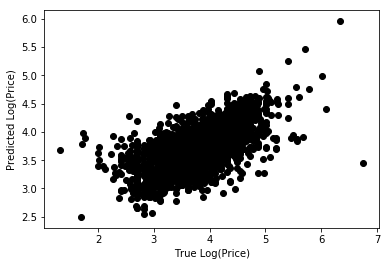

Test MSE: 0.14
R Squared: 0.43


In [17]:
y_pred = model.predict(X_test)
plt.scatter(y_test, y_pred,  color='black')
plt.xlabel('True Log(Price)')
plt.ylabel('Predicted Log(Price)')
plt.show()

print('Test MSE: %.2f' % mean_squared_error(y_test, y_pred))
print('R Squared: %.2f' % r2_score(y_test, y_pred))

Bottom-line MLP performed better than Linear Regression, worse than Random Forests.

3. But MLP isn't what we're here for. The DL method to go to when dealing with text is currently [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory).

    If we made it in class - great, if not, here is how it's done:

In [20]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer

maxlen = 20
batch_size = 128
epochs = 50
max_features = 15000

all_df = pd.concat([train_df, test_df])
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_df['title'].values)
X = tokenizer.texts_to_sequences(all_df['title'].values)
X = sequence.pad_sequences(X, maxlen = maxlen)

X_tr = X[:20000, :]
X_te = X[20000:, :]
print(X_tr.shape)
print(X_te.shape)

(20000, 20)
(5000, 20)


In [51]:
model = Sequential()
model.add(Embedding(max_features, 256))
model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error',
              optimizer='adam')

In [52]:
history = model.fit(X_tr, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_data=(X_te, y_test), callbacks = [EarlyStopping(patience = 5)])

Train on 20000 samples, validate on 5000 samples
Epoch 1/50
20000/20000 [==============================] - 30s 1ms/step - loss: 0.8962 - val_loss: 0.2221
Epoch 2/50
20000/20000 [==============================] - 29s 1ms/step - loss: 0.2093 - val_loss: 0.1936
Epoch 3/50
20000/20000 [==============================] - 31s 2ms/step - loss: 0.1579 - val_loss: 0.1645
Epoch 4/50
20000/20000 [==============================] - 31s 2ms/step - loss: 0.1214 - val_loss: 0.1834
Epoch 5/50
20000/20000 [==============================] - 32s 2ms/step - loss: 0.1000 - val_loss: 0.1486
Epoch 6/50
20000/20000 [==============================] - 32s 2ms/step - loss: 0.0894 - val_loss: 0.1592
Epoch 7/50
20000/20000 [==============================] - 33s 2ms/step - loss: 0.0822 - val_loss: 0.1455
Epoch 8/50
20000/20000 [==============================] - 31s 2ms/step - loss: 0.0749 - val_loss: 0.1495
Epoch 9/50
20000/20000 [==============================] - 32s 2ms/step - loss: 0.0687 - val_loss: 0.1483
Epoch 

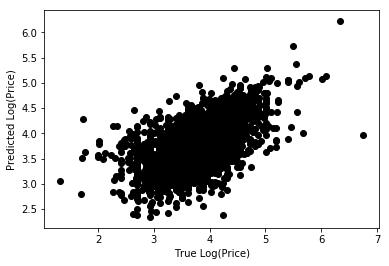

Test MSE: 0.15
R Squared: 0.38


In [53]:
y_pred = model.predict(X_te)
plt.scatter(y_test, y_pred,  color='black')
plt.xlabel('True Log(Price)')
plt.ylabel('Predicted Log(Price)')
plt.show()

print('Test MSE: %.2f' % mean_squared_error(y_test, y_pred))
print('R Squared: %.2f' % r2_score(y_test, y_pred))

The not so impressive of LSTM here only goes to show how hard a task price prediction can be.

4. Lastly it is interesting whether title + image can improve on predicting a shirt's price.

    This is somewhat more complicated architecture, called a "Bi-Modal" Network, as it gets its outputs from two different kinds of data. Once the each type of data is "flattened" into a vector they are simply glued together and we can add more layers as we please. To make it more schematic:
    
    <img src = "multi_modal_nn.png" width ="50%" height = "50%">

Get the images data again:

In [1]:
import sys
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform, color, img_as_ubyte

%matplotlib inline

def get_file_list(df, folder, n_sample = None, seed = None):
    if n_sample is None:
        file_ids_list = df.file_id.values
    else:
        file_ids_list = df.sample(n = n_sample, random_state = seed).file_id.values
    files_list = [folder + '/' + str(file_id) + '.jpg' for file_id in file_ids_list]
    return files_list

def read_image_and_resize(f, w = 100, h = 100):
    img = plt.imread(f)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        img = transform.resize(img, (w, h), mode='constant')
        img = img_as_ubyte(img)
    img = color.gray2rgb(img)
    img = img[np.newaxis, :, :, :3]
    if img.shape != (1, 100, 100, 3):
        raise ValueError(f + str(img.shape))
    return img

def read_images_4d_array(files_list):
    images_list = [read_image_and_resize(file) for file in files_list]
    images_array = np.concatenate(images_list)
    return images_array

def get_images_matrix(csv_file, folder, n = None, seed = 1976):
    df = pd.read_csv(csv_file)
    files_list = get_file_list(df, folder, n, seed)
    images = read_images_4d_array(files_list)
    return images, files_list

def get_all_pixels(x):
    return x.reshape(-1, np.prod(x.shape[1:]))

def numpy_array_size_in_bytes(a):
    return a.size * a.itemsize

def shape_and_size(x, name):
    n_rows = x.shape[0]
    if len(x.shape) == 1:
        n_cols = 1
    elif len(x.shape) == 2:
        n_cols = x.shape[1]
    else:
        warnings.warn('Function is meaningful for 1 or 2-D numpy arrays, taking 2nd dimension as n_cols')
        n_cols = x.shape[1]        
    size = numpy_array_size_in_bytes(x)
    print('%s Shape: %d X %d, Size (bytes): %d' % (name, n_rows, n_cols, size))

def conf_matrix(y_true, y_pred):
    return pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

def get_final_matrices(n_train = None, n_test = None):
    folder = 'ebay_boys_girls_shirts/'
    x_boys_train, boys_train_files = get_images_matrix(folder + 'boys_train.csv', folder + 'boys', n_train)
    x_boys_test, boys_test_files = get_images_matrix(folder + 'boys_test.csv', folder + 'boys', n_test)
    x_girls_train, girls_train_files = get_images_matrix(folder + 'girls_train.csv', folder + 'girls', n_train)
    x_girls_test, girls_test_files = get_images_matrix(folder + 'girls_test.csv', folder + 'girls', n_test)
    
    x_boys_train_all = get_all_pixels(x_boys_train)
    x_boys_test_all = get_all_pixels(x_boys_test)
    x_girls_train_all = get_all_pixels(x_girls_train)
    x_girls_test_all = get_all_pixels(x_girls_test)

    x_train = np.vstack([x_boys_train_all, x_girls_train_all])
    x_test = np.vstack([x_boys_test_all, x_girls_test_all])

    y_boys_train = np.array([0] * x_boys_train.shape[0])
    y_boys_test = np.array([0] * x_boys_test.shape[0])
    y_girls_train = np.array([1] * x_girls_train.shape[0])
    y_girls_test = np.array([1] * x_girls_test.shape[0])
    y_train = np.concatenate([y_boys_train, y_girls_train])
    y_test = np.concatenate([y_boys_test, y_girls_test])
    
    return x_train, x_test, y_train, y_test

In [2]:
x_train, x_test, y_train_cl, y_test_cl = get_final_matrices() # we call this y_train_cl because these are the classification labels
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

shape_and_size(x_train, 'x_train')
shape_and_size(x_test, 'x_test')
shape_and_size(y_train_cl, 'y_train_cl')
shape_and_size(y_test_cl, 'y_test_cl')

x_train Shape: 20000 X 30000, Size (bytes): 2400000000
x_test Shape: 5000 X 30000, Size (bytes): 600000000
y_train_cl Shape: 20000 X 1, Size (bytes): 160000
y_test_cl Shape: 5000 X 1, Size (bytes): 40000


In [26]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, concatenate, Embedding, LSTM
from keras.engine.input_layer import Input
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping

img_rows, img_cols, channels = 100, 100, 3

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, channels)

model_image = Sequential()
model_image.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_image.add(Conv2D(64, (3, 3), activation='relu'))
model_image.add(MaxPooling2D(pool_size=(2, 2)))
model_image.add(Dropout(0.25))
model_image.add(Flatten())

image_input = Input(shape = (100, 100, 3), name = "image_input")
encoded_image = model_image(image_input)

In [27]:
max_features = 15000
maxlen = 20

model_title = Sequential()
model_title.add(Embedding(max_features, 256))
model_title.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2))

title_input = Input(shape = (maxlen,), name = "title_input")
encoded_title = model_title(title_input)

In [28]:
output = concatenate([encoded_title, encoded_image])
output = Dense(units = 1, activation = 'linear')(output)

image_title_model = Model(inputs = [image_input, title_input], outputs = output)

image_title_model.compile(loss='mean_squared_error', optimizer='adam')

history = image_title_model.fit(x = {'image_input': x_train, 'title_input': X_tr}, y = y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_data=[{'image_input': x_test, 'title_input': X_te}, y_test],
                    callbacks = [EarlyStopping(patience = 5)])

Train on 20000 samples, validate on 5000 samples
Epoch 1/50
20000/20000 [==============================] - 213s 11ms/step - loss: 2.0606 - val_loss: 0.1813
Epoch 2/50
20000/20000 [==============================] - 221s 11ms/step - loss: 0.1620 - val_loss: 0.1473
Epoch 3/50
20000/20000 [==============================] - 227s 11ms/step - loss: 0.1241 - val_loss: 0.1495
Epoch 4/50
20000/20000 [==============================] - 228s 11ms/step - loss: 0.0998 - val_loss: 0.1433
Epoch 5/50
20000/20000 [==============================] - 227s 11ms/step - loss: 0.0884 - val_loss: 0.1392
Epoch 6/50
20000/20000 [==============================] - 228s 11ms/step - loss: 0.0754 - val_loss: 0.1515
Epoch 7/50
20000/20000 [==============================] - 228s 11ms/step - loss: 0.0654 - val_loss: 0.1675
Epoch 8/50
20000/20000 [==============================] - 229s 11ms/step - loss: 0.0606 - val_loss: 0.1472
Epoch 9/50
20000/20000 [==============================] - 228s 11ms/step - loss: 0.0556 - val_l

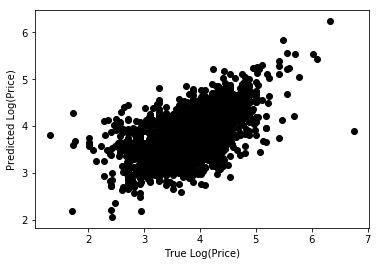

Test MSE: 0.14
R Squared: 0.40


In [29]:
y_pred = image_title_model.predict({'image_input': x_test, 'title_input': X_te})
plt.scatter(y_test, y_pred,  color='black')
plt.xlabel('True Log(Price)')
plt.ylabel('Predicted Log(Price)')
plt.show()

print('Test MSE: %.2f' % mean_squared_error(y_test, y_pred))
print('R Squared: %.2f' % r2_score(y_test, y_pred))

The images CNN improved somewhat on the title LSTM but not that much. Random Forests results are still better!

5. Can you do better?

In [ ]:
### YOUR CODE HERE ###